<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/FINAL_MODEL_AAE_simplified_PED1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imageio
!pip install progress
#!pip install tensorflow_datasets
!pip install keras-layer-normalization
from google.colab import drive
#!pip install alive-progress
drive.mount('/content/drive', force_remount=True)


  Created wheel for progress: filename=progress-1.5-cp36-none-any.whl size=8074 sha256=1e78a230e5b3cd6dcef420023c60f07ca05fbbcd019c3fc271f751b2d6bf9c92
  Stored in directory: /root/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
Successfully built progress
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp36-none-any.whl size=5268 sha256=25deb59630481af2b8f4982af2bcb84500a2f41a16476d71770cb3baf8b98eee
  Stored in directory: /root/.cache/pip/wheels/54/80/22/a638a7d406fd155e507aa33d703e3fa2612b9eb7bb4f4fe667
Successfully built keras-layer-normalization
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import skimage
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
import statistics
import shutil

import matplotlib.pyplot as plt

import time
from progress.bar import IncrementalBar

import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Dropout, Activation, InputLayer, MaxPool3D
from keras.optimizers import Adam
from keras_layer_normalization import LayerNormalization
from keras.models import load_model

Using TensorFlow backend.


In [0]:
class Config:
    def __init__(self, data_dir_, cwdir_name_, data_set):
        self.data_set_name = data_set
        self.data_dir = data_dir_
        self.data_set_dir = join(self.data_dir, data_set)
        self.cwdir_name = cwdir_name_
        self.cwdir = join(self.data_dir,self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        if not os.path.exists(self.cwdir):
            os.mkdir(self.cwdir)
            os.mkdir(self.run_data)
    
        if not os.path.exists(self.run_data):
            #shutil.rmtree(self.run_data)
            os.mkdir(self.run_data)
            os.makedirs(self.image_dir, exist_ok=True)

        self.DATASET_PATH = join(self.data_set_dir,"Train/")
        self.TEST_DIR = join(self.data_set_dir,"Test/")
        self.BATCH_SIZE = 2
        self.EPOCHS = 50
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = 0
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1
        self.latent_dim = 327680
        self.curr_epoch = 0

    def reconfig(self, new_name, batch_size = 4, epochs = 5, retrain = 0, curr_epoch = 0):
        self.cwdir_name = new_name
        self.cwdir = join(self.data_dir, self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")

        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = retrain
        if retrain == 0:
            print("Configuring train from scratch")
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
    
            if os.path.exists(self.run_data):
                shutil.rmtree(self.run_data)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)
        else:
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)

        self.curr_epoch = curr_epoch

conf = Config(data_dir_="/content/drive/My Drive/", cwdir_name_="Conv2DLSTM_AAE_PED1", data_set="UCSD_Anomaly_Dataset.v1p2/UCSDped1/") 


In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):

    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_clips_list(seq_size):

    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))

                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 32-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seq_size))
    
    #print(np.array(clips).shape)
    return np.array(clips)


def get_single_test(single_test_path):

    sz = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
          sz = sz +1

    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

def get_test_sequences(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return sequences

def convert_images_back(image):
    return np.reshape(image,(256, 256))*256.0
    #print(image.shape)
    #return np.reshape(image[:, :, 0],(image.shape[0], image.shape[1]))*127.5 + 127.5




In [5]:
def build_model_enc(path=""):
    if conf.retrain == 1 and os.path.isfile(path):
        model_gen=load_model(path, custom_objects={'LayerNormalization': LayerNormalization})
        return model_gen
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, activation="relu", padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, activation="relu", padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(Flatten())
    seq.summary(line_length=150)
    return  seq

def build_model_dec(path=""):
    if conf.retrain == 1 and os.path.isfile(path):
        model_gen=load_model(path, custom_objects={'LayerNormalization': LayerNormalization})
        return model_gen
    seq = Sequential()
    seq.add(Reshape((10, 32, 32, 32), input_shape=(conf.latent_dim,)))
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, activation="relu", padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, activation="relu", padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    seq.summary(line_length=150)
    return seq

def build_model_disc(path=""):
    if conf.retrain == 1 and os.path.isfile(path):
        model_gen=load_model(path, custom_objects={'LayerNormalization': LayerNormalization})
        return model_gen
    seq = Sequential()
    model = Sequential()
    seq.add(Reshape((10, 32, 32, 32), input_shape=(conf.latent_dim,)))
    seq.add(TimeDistributed(Conv2D(16, (3, 3), strides=2, activation="relu", padding="same")))
    seq.add(MaxPool3D(pool_size=(2, 2, 2), strides=2, padding='valid'))
    seq.add(Flatten())
    seq.add(Dropout(0.4))
    seq.add(Dense(1, activation="sigmoid"))
    seq.summary(line_length=150)
    return seq

build_model_enc()
build_model_dec()
build_model_disc()

Model: "sequential_1"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
time_distributed_1 (TimeDistributed)                               (None, 10, 64, 64, 128)                                     15616                  
______________________________________________________________________________________________________________________________________________________
layer_normalization_1 (LayerNormalization)                         (None, 10, 64, 64, 128)                                     256                    
______________________________________________________________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)                               (None

In [0]:
def build_model_aae(enc_path, dec_path, disc_path):
    model_enc = build_model_enc(enc_path)
    model_dec = build_model_dec(dec_path)
    model_disc = build_model_disc(disc_path)
    
    model_ae = Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)
    
    model_enc_disc = Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)
    
    model_enc.summary()
    model_dec.summary()
    model_disc.summary()
    model_ae.summary()
    model_enc_disc.summary()

    model_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
    model_enc_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
    model_ae.compile(optimizer=Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), loss="mse")
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

 

In [0]:


def reconstruct_batch(model, sequences, epoch, folder_name):

    sz = sequences.shape[0]
    #InX = Input(shape=sequences.shape[1:]) 
    #tmpModel = Model(inputs=InX, outputs=model.get_layer("convTD5").output)
    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)

    path = join(conf.run_data,folder_name, str(epoch)+"_epoch")
    os.makedirs(path, exist_ok=True)
    for i in range(0, sz):
        #cv2_imshow(np.reshape(reconstructed_sequences[i][2],(256, 256))*256)
        if i < 10:
            img_num = "00"+str(i)
        elif i < 100:
            img_num = "0"+str(i)
        else:
            img_num = str(i)
        print("Reconstructing : "+ str(reconstructed_sequences.shape))
        cv2.imwrite(join(path,"gen_"+img_num+".jpg"), convert_images_back(reconstructed_sequences[i][6]))
        
def settrainable(model, toset):
    for layer in model.layers:
        layer.trainable = toset
    model.trainable = toset




def evaluate_gen(sequences, model, test_case_dir, epoch=conf.EPOCHS):

    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    
    sz = sequences.shape[0]
    
    print("Test size:"+str(sz))
   
    os.makedirs(join(conf.image_dir,test_case_dir,"epoch_"+str(epoch)), exist_ok=True)
    for i in range(0, sz):
        #print("sz "+str(i)+"\n")
        #cv2_imshow(np.reshape(reconstructed_sequences[i][2],(256, 256))*256)
        if i < 10:
            img_num = "00"+str(i)
        elif i < 100:
            img_num = "0"+str(i)
        else:
            img_num = str(i)    
        
        cv2.imwrite(join(conf.image_dir, test_case_dir, "epoch_"+str(epoch),"gen_"+img_num+".jpg"), convert_images_back(reconstructed_sequences[i][6]))


def evaluate_dis(sequences, model, test_case_dir, epoch=conf.EPOCHS):
    sr = model.predict(sequences,batch_size=conf.BATCH_SIZE)

    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.savefig(join(conf.image_dir, test_case_dir, "epoch_"+str(epoch),"regularity_score.jpg"))
    plt.show()

def plot_history(d1_hist, d2_hist, d3_hist, image_name):
	# plot history
	plt.plot(d1_hist, label='ae_loss')
	plt.plot(d2_hist, label='disc_loss')
	plt.plot(d3_hist, label='enc_disc_loss')
	plt.legend()
	plt.savefig(image_name)
	plt.close()

Test case loaded
Test data set loaded
Train data set loaded
Model: "sequential_5"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
time_distributed_7 (TimeDistributed)                               (None, 10, 64, 64, 128)                                     15616                  
______________________________________________________________________________________________________________________________________________________
layer_normalization_9 (LayerNormalization)                         (None, 10, 64, 64, 128)                                     256                    
______________________________________________________________________________________________________________________________________________________
time_distrib

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Test size:190


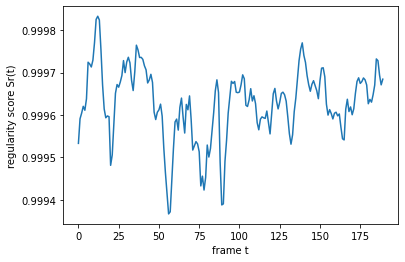

Reconstruction Loss: 0.008738145155503469
Adverserial Loss: 0.0003064046352793572
Epoch 52


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Test size:190


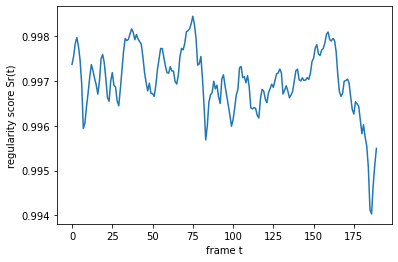

KeyboardInterrupt: ignored

In [8]:
import csv


test_cases_dir = "Test008"
test_cases = get_test_sequences(test_cases_dir)
print("Test data set loaded")
conf.reconfig(new_name="Conv2DLSTM_AAE_PED1", batch_size=4, epochs=100, retrain=1, curr_epoch=50)
x_train = get_clips_list(conf.dim1)

print("Train data set loaded")


model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae(enc_path=conf.GEN_MODEL_PATH+str("ep"+str(conf.curr_epoch+1)), dec_path=conf.DEC_MODEL_PATH+str("ep"+str(conf.curr_epoch+1)), disc_path=conf.DIS_MODEL_PATH+str("ep"+str(conf.curr_epoch+1)))


batchsize = conf.BATCH_SIZE


for epochnumber in range(conf.curr_epoch, conf.EPOCHS):
    print("Epoch "+str(epochnumber+1))
    d1_hist, d2_hist, d3_hist = list(), list(), list()
    with open(join(conf.run_data, 'loss_val.csv'), mode='a') as csv_file:
        fieldnames = ['epoch_num', 'batch_num', 'ae_loss', 'disc_loss', 'enc_disc_loss']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(int(len(x_train) / batchsize)):
    
            settrainable(model_ae, True)
            settrainable(model_enc, True)
            settrainable(model_dec, True)
        
            batch = x_train[i*batchsize:i*batchsize+batchsize]
            ae_loss = model_ae.train_on_batch(batch, batch)
            
            
            settrainable(model_disc, True)
            batchpred = model_enc.predict(batch)
            #fakepred = np.random.standard_normal((batchsize, conf.latent_dim))
            fakepred = np.random.normal(loc=0.0, scale=1, size=(batchsize, conf.latent_dim))
            discbatch_x = np.concatenate([batchpred, fakepred])
            discbatch_y = np.concatenate([np.zeros(batchsize), np.ones(batchsize)])
            disc_loss = model_disc.train_on_batch(discbatch_x, discbatch_y)
        
            settrainable(model_enc_disc, True)
            settrainable(model_enc, True)
            settrainable(model_disc, False)
            enc_disc_loss = model_enc_disc.train_on_batch(batch, np.ones(batchsize))
            #print("ae_loss:"+str(ae_loss)+", disc_loss:"+str(disc_loss)+", enc_disc_loss:"+str(enc_disc_loss))
            d1_hist.append(ae_loss)
            d2_hist.append(disc_loss)
            d3_hist.append(enc_disc_loss)

            writer.writerow({'epoch_num': epochnumber, 'batch_num': i, 'ae_loss': ae_loss, 'disc_loss': disc_loss, 'enc_disc_loss': enc_disc_loss})
        csv_file.close()
    plot_history(d1_hist, d2_hist, d3_hist, join(conf.run_data,"plot_ep_"+str(epochnumber+1)))
    model_enc.save(conf.GEN_MODEL_PATH+str("ep"+str(epochnumber+1)))
    model_dec.save(conf.DEC_MODEL_PATH+str("ep"+str(epochnumber+1)))
    model_disc.save(conf.DIS_MODEL_PATH+str("ep"+str(epochnumber+1)))
    evaluate_gen(test_cases, model_ae, test_cases_dir, epochnumber+1)
    evaluate_dis(test_cases, model_enc_disc, test_cases_dir, epochnumber+1)
    print ("Reconstruction Loss:", model_ae.evaluate(x_train, x_train, verbose=0, batch_size=conf.BATCH_SIZE))
    print ("Adverserial Loss:", model_enc_disc.evaluate(x_train, np.ones(len(x_train)), verbose=0, batch_size=conf.BATCH_SIZE))


